In [1]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import describe
import datetime
from datetime import timedelta as timedelta
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
import sklearn.utils as sku
from scipy import signal
import os, sys
sys.path.append( '/home/ugrads/c/clearloveyanzhen/CufflessBP/bioz_processing' )
import sicong_util as su
import sicong_duck_path as sp
import sicong_duck_path as sdp
plt.rcParams.update({'font.size': 13})
import seaborn as sns
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader , TensorDataset
import torch.autograd as autograd
from torch import Tensor
from sklearn import svm
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression

/home/ugrads/c/clearloveyanzhen/miniconda3/envs/torch/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [24]:
def label_binary_converter(in_x, in_y, bp_type='sbp', in_vals=[140, 150], thre=[-3, +3], out_vals=[0,1], balanced_out=True, resample=False):
    # in_x=X; in_y=y; bp_type='sbp'; in_vals=[120, 160]; thre=[-2, +2]; out_vals=[0,1]; balanced_out=True
    if bp_type == 'sbp':
        out_y=in_y[:,0]
    else:
        out_y=in_y[:,1]
    out_y=in_y[((in_y >= in_vals[0]+thre[0])&(in_y <= in_vals[0]+thre[1])) | ((in_y >= in_vals[1]+thre[0])&(in_y <= in_vals[1]+thre[1]))]
    out_y=np.where(out_y < in_vals[1]+thre[0], 0, 1)
    out_x=in_x[((in_y >= in_vals[0]+thre[0])&(in_y <= in_vals[0]+thre[1])) | ((in_y >= in_vals[1]+thre[0])&(in_y <= in_vals[1]+thre[1]))]
    if resample:
        out_x, out_y = sku.resample(out_x, out_y)
    if balanced_out:
        len_out=min(np.count_nonzero(out_y==0), np.count_nonzero(out_y==1))
        
    return out_x, out_y

def Binary_Model_Runner(X, y, label_list = [120, 130], split_size=0.2, resample=True):
    if resample:
        print('resampling')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42)
    else:
        X_train, X_test = X[:int(X.shape[0]*(1-split_size)), :], X[int(X.shape[0]*(1-split_size)):, :]
        y_train, y_test = y[:int(X.shape[0]*(1-split_size))], y[int(X.shape[0]*(1-split_size)):]
        
    # lr = LogisticRegression(random_state=0)
    xgb = xgboost.XGBClassifier(objective='binary:logistic', eval_metric='logloss', max_depth=3, use_label_encoder=False)
    models_used = {'xgb':xgb}
    model_names = {'xgb':'XGBoost'}
    colors_used = {'xgb': 'blue'}
    scores = {}
    for model in models_used:
        scores[model] = cross_val_score(models_used[model], X, y, cv=10, scoring='f1')
    plt.title(f'cross validation F1 Scores ({label_list[0]} vs. {label_list[1]} mmHg)')
    for model in scores:
        plt.plot(scores[model], color=colors_used[model], label=model_names[model])
        plt.axhline(np.mean(scores[model]), color=colors_used[model], label=str(np.mean(scores[model]))[:5])
        plt.ylim([0.5, 1])
        print(model)
        print(f'Average={np.mean(scores[model])} with STD={np.std(scores[model])}')
    plt.legend()
    plt.show()
    plt.close()
    for model in models_used:
        models_used[model].fit(X_train, y_train)
        y_pred = models_used[model].predict(X_test)
        print(f'result of one prediction={f1_score(y_test, y_pred)} with resample={resample}')
    plot_confusion_matrix(models_used['xgb'], X_test, y_test, display_labels=[str(label_list[0]), str(label_list[1])])
    plt.title('Confusion Matrix of BP Classification from BioZ Waveform')
    plt.show()
    return models_used, scores

In [198]:
out_y[np.sort(np.concatenate((np.where(out_y==1)[0][:233],np.where(out_y==0)[0][:233])))]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
binary_pairs = []
for a in np.arange(120, 161, 10):
    for b in np.arange(a, 161, 10):
        if a != b:
            binary_pairs.append([a, b])

In [82]:
X = np.concatenate((X[:,-900:], X[:,2100:3000]), axis=1)

(16527, 1800)

In [349]:
X = np.load('X_file.npy')
y = np.load('y_file.npy')
# X = X[:,-1800:]
X = np.concatenate((X[:,2100:3000], X[:,-900:]), axis=1)
mm = MinMaxScaler()
X = mm.fit_transform(X)
# X, y = label_binary_converter(in_x=X, in_y=y)

[150, 160]
(2586, 1800) (2586,)
xgb
Average=0.8519364460877992 with STD=0.022123135434610874


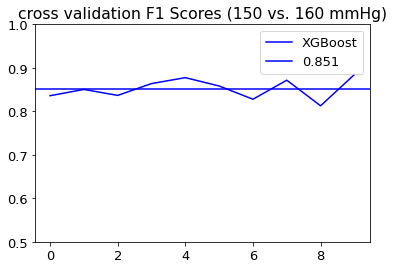

result of one prediction=0.8131416837782341 with resample=False


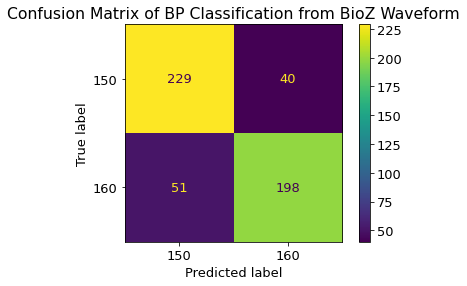

In [263]:
import warnings
warnings.filterwarnings('ignore')
for pair in [binary_pairs[-1]]:
    print(pair)
    bin_x, bin_y = label_binary_converter(in_x=X, in_y=y, in_vals=pair, balanced_out=True, resample=False)
    print(bin_x.shape, bin_y.shape)
    models_used, scores = Binary_Model_Runner(X=bin_x, y=bin_y, label_list=pair, split_size=0.2, resample=False)

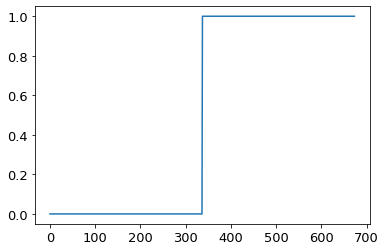

In [16]:
# for model in models_used:
#     scores[model] = cross_val_score(models_used[model], X, y, cv=10, scoring='f1')
# plt.title(f'cross validation F1 Scores ({label_list[0]} vs. {label_list[1]} mmHg)')
plt.plot(bin_y)

In [194]:
# for model in models_used:
#     models_used[model].fit(X_train, y_train)
#     y_pred = models_used[model].predict(X_test)
#     print(f1_score(y_test, y_pred))

0.8691392582225332


In [49]:
# plot_confusion_matrix(models_used['xgb'], X_test, y_test, display_labels=['140', '150'])
# plt.title('Confusion Matrix of subset of data')

In [27]:
models_used['xgb']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=48,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [34]:
import shap
shap.__version__

'0.39.0'

In [256]:
explainer = shap.Explainer(models_used['xgb'])
shap_test = explainer(bin_x[:100,:])
print(f"Length of shap_test: {len(shap_test)}\n")
print(f"Sample shap_test:\n{shap_test[2,:]}")

Length of shap_test: 100

Sample shap_test:
.values =
array([-0.00426762,  0.        ,  0.06017034, ...,  0.01815607,
       -0.01475287,  0.01040595], dtype=float32)

.base_values =
0.036654748

.data =
array([0.32163316, 0.32182904, 0.3219671 , ..., 0.45806846, 0.45902259,
       0.46123809])


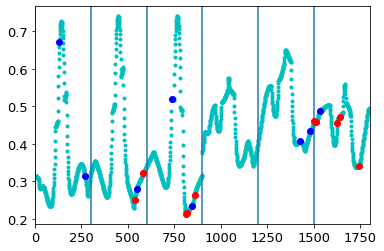

In [279]:
val_name=[1642, 815, 1514, 859, 537, 1745, 820, 1503, 584, 1626, 132, 270, 845, 1482, 737, 1426, 1534, 548]
# val_name=[845,487,1644,851,537,1426,516,831,131,1799,859,607,1427,132,1294,161,437,73,985,1534,680,426,860]
bin_x[1,:] = bin_x[2,:]
plt.plot(signal_sample, 'c.')
plt.xlim([0,1800])
for each in np.arange(1,len(signal_sample), 300):
    plt.axvline(each)
plt.plot(val_name[:10], signal_sample[val_name[:10]], 'ro')
plt.plot(val_name[10:], signal_sample[val_name[10:]], 'bo')

In [261]:
bin_x[1,:].shape

(1800,)

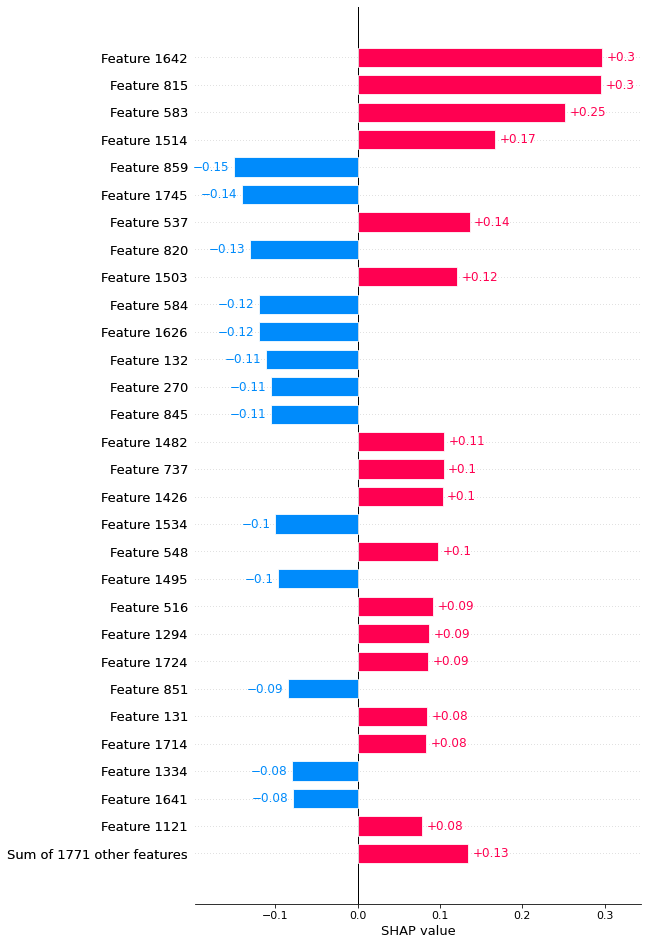

In [272]:
shap.plots.bar(shap_test[2], max_display=30)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2586
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2078.561
Date:                Wed, 18 May 2022   AIC                           4169.121
Time:                        12:10:15   BIC                           4204.266
Sample:                             0   HQIC                          4181.859
                               - 2586                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7971      0.020    -39.745      0.000      -0.836      -0.758
ar.L2         -0.6150      0.025    -24.616      0.000      -0.664      -0.566
ar.L3         -0.4714      0.026    -17.966      0.0

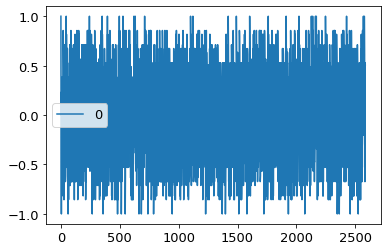

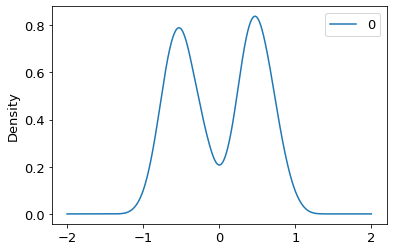

                  0
count  2.586000e+03
mean  -7.711181e-05
std    5.410035e-01
min   -1.000000e+00
25%   -5.085247e-01
50%    1.110223e-16
75%    4.909234e-01
max    1.000000e+00


In [291]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

arima = ARIMA(bin_y[:], order=(5,1,0))
arima_fit = arima.fit()
print(arima_fit.summary())
residuals = DataFrame(arima_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [345]:
def extract_peak(X):
    peaks = []
    for each in X:
        peaks.append(np.max(each))
    return peaks
def extract_trough(X):
    troughs = []
    for each in X:
        troughs.append(np.min(each[600:900]))
    return troughs
def extract_ptt_peak(X):
    ptts = []
    for each in X:
        ptts.append(np.max(each[600:900])-np.max(each[-300:]))
    return ptts
def extract_ptt_trough(X):
    ptts = []
    for each in X:
        ptts.append(np.min(each[600:900])-np.min(each[-300:]))
    return ptts
peaks=extract_peak(X)
troughs=extract_trough(X)
ptt_peaks=extract_ptt_peak(X)
ptt_troughs=extract_ptt_trough(X)

epoch=0.000000, predicted=0.745407, expected=0.746858
epoch=1.000000, predicted=0.747232, expected=0.746142


Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=4.000000, predicted=0.746262, expected=0.749320
epoch=9.000000, predicted=0.747170, expected=0.747069
epoch=24.000000, predicted=0.749132, expected=0.747537


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=49.000000, predicted=0.748560, expected=0.746997
Test RMSE: 0.002


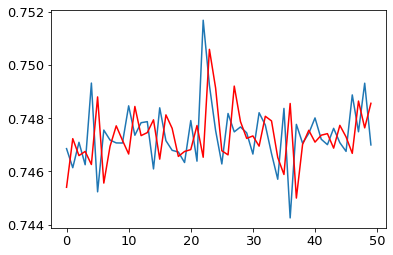

In [347]:
train, test = peaks[:1500], peaks[1500:1550]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if len(test) % (1+t) == 0:
        print('epoch=%f, predicted=%f, expected=%f' % (t, yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=0.000000, predicted=0.744915, expected=123.489380
epoch=1.000000, predicted=351.708632, expected=127.410889


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=4.000000, predicted=297.418237, expected=122.665405


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


epoch=9.000000, predicted=52.336627, expected=124.328613
epoch=24.000000, predicted=120.032307, expected=123.931885
epoch=49.000000, predicted=130.467776, expected=132.171631
Test RMSE: 52.751


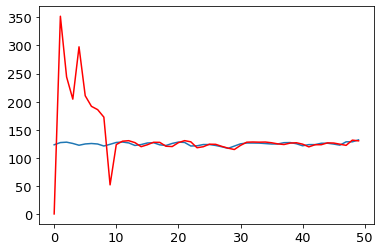

In [395]:
train, test = peaks[:1500], in_y[1500:1550]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if len(test) % (t+1) == 0:
        print('epoch=%f, predicted=%f, expected=%f' % (t, yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

epoch=0.000000, predicted=0.192203, expected=73.745728
epoch=1.000000, predicted=236.240514, expected=72.494507
epoch=2.000000, predicted=32.393916, expected=73.364258
epoch=4.000000, predicted=50.996174, expected=70.556641
epoch=5.000000, predicted=74.954189, expected=69.061279
epoch=9.000000, predicted=78.004104, expected=80.032349
epoch=14.000000, predicted=84.305598, expected=83.816528
epoch=24.000000, predicted=79.577190, expected=79.589844
epoch=29.000000, predicted=81.953664, expected=83.160400
epoch=49.000000, predicted=86.222574, expected=83.648682
epoch=74.000000, predicted=79.367465, expected=77.789307
epoch=149.000000, predicted=83.289862, expected=86.090088
Test RMSE: 1.727


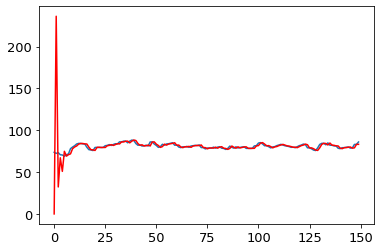

In [441]:
train, test = troughs[:1400], y[1400:1550,1]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    if len(test) % (t+1) == 0:
        print('epoch=%f, predicted=%f, expected=%f' % (t, yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test[5:], predictions[5:]))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [438]:
rmse = sqrt(mean_squared_error(test[10:], predictions[10:]))
rmse

1.6456898232073216

201 250
rmse=3.0316805589103972


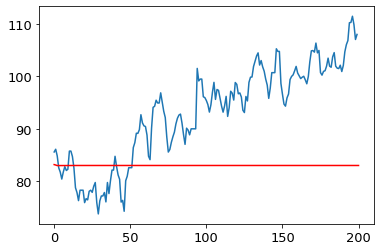

In [442]:
output = model_fit.predict(1550, 1750, dynamic=False)
print(len(output), len(y[1500:1750,1]))
pyplot.plot(y[1550:1750,1])
pyplot.plot(output, color='red')
print(f'rmse={sqrt(mean_squared_error(y[1510:1550,1], output[10:50]))}')

In [443]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1549
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3218.128
Date:                Wed, 18 May 2022   AIC                           6448.256
Time:                        16:25:24   BIC                           6480.324
Sample:                             0   HQIC                          6460.183
                               - 1549                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0079      0.065     -0.122      0.903      -0.135       0.119
ar.L2          0.0158      0.099      0.160      0.873      -0.178       0.209
ar.L3         -0.0358      0.119     -0.301      0.7

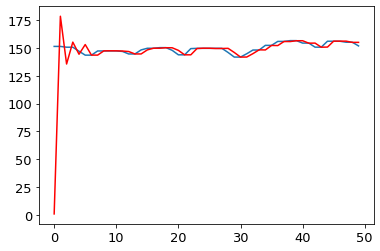

In [361]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [375]:
mbp=get_mbp(sbp, dbp)

In [380]:
mbp

[0.5667780602808613,
 155.40948761513036,
 116.37441745206733,
 135.4518615843028,
 125.17564515809983,
 132.77373298311036,
 125.71733389930966,
 125.67609117219591,
 128.2879948061347,
 128.29155382558295,
 128.97300166337575,
 128.84234507456995,
 128.5430094743939,
 127.76151424117059,
 127.77943296685783,
 129.8359690926431,
 131.44400185490323,
 131.4473824449616,
 132.19828283604497,
 132.1372417900634,
 130.01796243554148,
 126.68167351237035,
 126.70789054035782,
 129.94779481797988,
 130.17552433238262,
 130.12727576112067,
 129.998158995816,
 129.97625006529796,
 130.07242938412392,
 127.18002595476257,
 123.86556816233148,
 123.87803345275178,
 127.08299387553218,
 128.5448443854751,
 128.49348380047056,
 132.85912323948193,
 132.81126742099147,
 135.2469154885358,
 135.18079431970503,
 136.8449934552631,
 136.81914067285544,
 134.47917644048337,
 134.5278425042675,
 131.88654309892374,
 131.96646178952577,
 134.70272763854027,
 134.72277244681723,
 134.7123256908038,
 134.

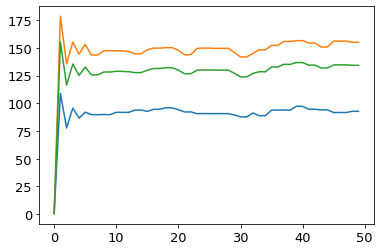

In [381]:
plt.plot(dbp)
plt.plot(sbp)
plt.plot(mbp)

In [379]:
def get_mbp(sbp, dbp):
    mbp = []
    for i, e in enumerate(sbp):
        mbp.append((sbp[i]+sbp[i]+dbp[i])/3)
        print(sbp[i], dbp[i], mbp[i])
    return mbp

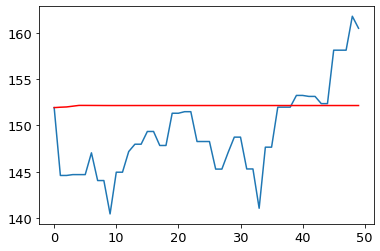

In [364]:
model = ARIMA(history, order=(5,1,0))
model_fit = model.fit()
output = model_fit.forecast(50)
pyplot.plot(y[2550:2600,0])
pyplot.plot(output, color='red')

In [363]:
len(history)

2550